In [2]:
import spacy

# word vectors occupy lot of space. hence en_core_web_sm model do not have them included. 
# In order to download
# word vectors you need to install large or medium english model. We will install the large one!
# make sure you have run "python -m spacy download en_core_web_lg" to install large english model
nlp = spacy.load("en_core_web_lg")

In [3]:
doc = nlp("dog cat banana kem")

for token in doc:
    print(token.text, "Vector:", token.has_vector, "OOV:", token.is_oov)

dog Vector: True OOV: False
cat Vector: True OOV: False
banana Vector: True OOV: False
kem Vector: False OOV: True


In [4]:
doc[0].vector.shape

(300,)

In [5]:
base_token = nlp("bread")
base_token.vector.shape

(300,)

In [6]:
doc = nlp("bread sandwich burger car tiger human wheat")

for token in doc:
    print(f"{token.text} <-> {base_token.text}:", token.similarity(base_token))

bread <-> bread: 1.0
sandwich <-> bread: 0.6341067010130894
burger <-> bread: 0.47520687769584247
car <-> bread: 0.06451533308853552
tiger <-> bread: 0.04764611675903374
human <-> bread: 0.2151154210812192
wheat <-> bread: 0.6150360888607199


In [7]:
def print_similarity(base_word, words_to_compare):
    base_token = nlp(base_word)
    doc = nlp(words_to_compare)
    for token in doc:
        print(f"{token.text} <-> {base_token.text}: ", token.similarity(base_token))

In [8]:
print_similarity("iphone", "apple samsung iphone dog kitten")

apple <-> iphone:  0.4387907401919904
samsung <-> iphone:  0.670859081425417
iphone <-> iphone:  1.0
dog <-> iphone:  0.08211864228011527
kitten <-> iphone:  0.10222317834969896


In [9]:
king = nlp.vocab["king"].vector
man = nlp.vocab["man"].vector
woman = nlp.vocab["woman"].vector
queen = nlp.vocab["queen"].vector

result = king - man + woman

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([result], [queen])

array([[0.61780137]], dtype=float32)

Problem Statement
Fake news refers to misinformation or disinformation in the country which is spread through word of mouth and more recently through digital communication such as What's app messages, social media posts, etc.

Fake news spreads faster than real news and creates problems and fear among groups and in society.

We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is Real or Fake Message.

We will use glove embeddings from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.

In [24]:
import pandas as pd

#read the dataset with name "Fake_Real_Data.csv" and store it in a variable df
df = pd.read_csv("/kaggle/input/fake-news/FakeNewsNet.csv")
#print the shape of dataframe
print(df.shape)

#print top 5 rows
df.head(5)

(23196, 5)


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [26]:
#check the distribution of labels 
df['real'].value_counts()

1    17441
0     5755
Name: real, dtype: int64

In [30]:
min_samples = 5755 # we have these many SCIENCE articles and SCIENCE is our minority class

df_real = df[df.real==1].sample(min_samples, random_state=2022)
df_fake = df[df.real==0].sample(min_samples, random_state=2022)

df = pd.concat([df_real,df_fake],axis=0)
df.real.value_counts()

1    5755
0    5755
Name: real, dtype: int64

In [32]:
import spacy
nlp = spacy.load("en_core_web_lg")

#This will take some time(nearly 15 minutes)
df['vector'] = df['title'].apply(lambda text: nlp(text).vector)  

In [33]:
df.head()

,title,news_url,source_domain,tweet_num,real,vector
5955,Chester Bennington: Linkin Park frontman's aut...,https://www.independent.co.uk/arts-entertainme...,www.independent.co.uk,125,1,"[-0.826824, -0.31476706, 1.768082, -1.5733689,..."
8315,Citizen Rose,https://en.wikipedia.org/wiki/Citizen_Rose,en.wikipedia.org,35,1,"[-1.265865, -0.083584994, 1.9670501, -0.409965..."
11857,The 'quietly depressing' photocall for Jennife...,https://www.stuff.co.nz/entertainment/film/101...,www.stuff.co.nz,56,1,"[-1.3920768, 1.3952583, 0.91308254, -0.7859000..."
2475,2017 ESPYS award winners,http://www.espn.com/espn/story/_/id/19974721/2...,www.espn.com,76,1,"[-0.675025, -3.7910748, 0.007580012, -0.799622..."
1035,interview with Bloomberg television,http://www.cq.com/doc/newsmakertranscripts-432...,www.cq.com,444,1,"[-2.3399925, -0.7050837, -0.6639275, 1.037935,..."


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.real,
    test_size=0.2,
    random_state=2022
)

In [35]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1121
           1       0.65      0.59      0.62      1181

    accuracy                           0.62      2302
   macro avg       0.63      0.63      0.62      2302
weighted avg       0.63      0.62      0.62      2302



In [38]:
from  sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1121
           1       0.70      0.64      0.67      1181

    accuracy                           0.67      2302
   macro avg       0.68      0.67      0.67      2302
weighted avg       0.68      0.67      0.67      2302



## Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

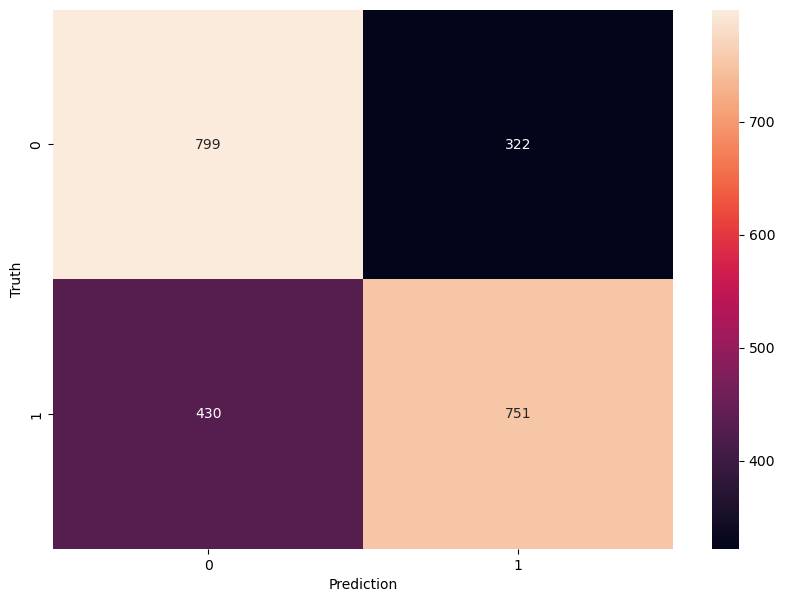

In [39]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

Key Takeaways
KNN model which didn't perform well in the vectorization techniques like Bag of words, and TF-IDF due to very high dimensional vector space, performed really well with glove vectors due to only 300-dimensional vectors and very good embeddings(similar and related words have almost similar embeddings) for the given text data.

MultinomialNB model performed decently well but did not come into the top list because in the 300-dimensional vectors we also have the negative values present. The Naive Bayes model does not fit the data if there are negative values. So, to overcome this shortcoming, we have used the Min-Max scaler to bring down all the values between 0 to 1. In this process, there will be a possibility of variance and information loss among the data. But anyhow we got a decent recall and f1 scores.

# GENSIM

In [ ]:
import gensim.downloader as api
# This is a huge model (~1.6 gb) and it will take some time to load

wv = api.load('word2vec-google-news-300')

[======================----------------------------] 44.7% 743.4/1662.8MB downloaded

In [ ]:
wv.similarity(w1="great", w2="good")

In [ ]:
wv.most_similar("good")

In [ ]:
wv.most_similar("dog")

In [ ]:
wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)

In [ ]:
wv.doesnt_match(["facebook", "cat", "google", "microsoft"])

In [ ]:
wv.doesnt_match(["dog", "cat", "google", "mouse"])

## Gensim Glove

In [ ]:
glv = api.load("glove-twitter-25")

glv.most_similar("good")

In [ ]:
glv.doesnt_match("breakfast cereal dinner lunch".split())

In [ ]:
glv.doesnt_match("facebook cat google microsoft".split())

In [ ]:
glv.doesnt_match("banana grapes orange human".split())